# Homework #7
---
Student Name: Sam Crane

Student ID: 801101091

GitHub: https://github.com/samofuture/Intro-to-ML

In [12]:
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
# use seaborn plotting defaults
import seaborn as sns; sns.set()
print(torch.cuda.device_count())
print(f"Version: {torch.__version__}, GPU: {torch.cuda.is_available()}, NUM_GPU: {torch.cuda.device_count()}")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1
Version: 2.1.1, GPU: True, NUM_GPU: 1


In [4]:
from torchvision import datasets, transforms
data_path = 'data-unversioned/p1ch7'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
to_tensor = transforms.ToTensor()

cifar10_tensor = datasets.CIFAR10(data_path, train=True, download=False, transform=to_tensor)

imgs = torch.stack([img_t for img_t, _ in cifar10_tensor], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

In [6]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

In [7]:
from sklearn import metrics

def validate(model, val_loader):
    num_correct = 0
    total_samples = 0
    predicted_classes = []
    val_outputs = []

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)

            _, predicted = torch.max(outputs, 1)
            num_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            predicted_classes.extend(predicted.cpu().numpy())
            val_outputs.extend(labels.cpu().numpy())

    accuracy = num_correct / total_samples
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

    model.train()  # Set the model back to training mode

    # Display confusion matrix
    class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

    print(metrics.classification_report(val_outputs, predicted_classes))
    
    cnf_matrix = metrics.confusion_matrix(val_outputs, predicted_classes)
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    # create heatmap
    sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g', xticklabels=class_names, yticklabels=class_names)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
        

## Problem 1a

In [7]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [8]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [37]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss().to(device)

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-10 12:16:45.620912 Epoch 1, Training loss 2.2800722706820316
2023-12-10 12:18:17.819029 Epoch 10, Training loss 1.8538836546784616
2023-12-10 12:20:00.183928 Epoch 20, Training loss 1.6116299738829163
2023-12-10 12:21:43.208025 Epoch 30, Training loss 1.4955438133400518
2023-12-10 12:23:26.574117 Epoch 40, Training loss 1.4137670386339969
2023-12-10 12:25:09.246841 Epoch 50, Training loss 1.3347787290697353
2023-12-10 12:26:50.439850 Epoch 60, Training loss 1.2716774278216891
2023-12-10 12:28:30.671552 Epoch 70, Training loss 1.2247503904547272
2023-12-10 12:30:12.619947 Epoch 80, Training loss 1.187387889600805
2023-12-10 12:31:53.613956 Epoch 90, Training loss 1.1561500838889929
2023-12-10 12:33:34.862204 Epoch 100, Training loss 1.1294020307018382
2023-12-10 12:35:16.495001 Epoch 110, Training loss 1.1035544072987933
2023-12-10 12:36:58.997716 Epoch 120, Training loss 1.0801695882132227
2023-12-10 12:38:40.268676 Epoch 130, Training loss 1.0570631013519463
2023-12-10 12:40:2

Validation Accuracy: 69.81%
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      5000
           1       0.80      0.82      0.81      5000
           2       0.61      0.56      0.59      5000
           3       0.53      0.49      0.51      5000
           4       0.64      0.65      0.65      5000
           5       0.60      0.58      0.59      5000
           6       0.75      0.77      0.76      5000
           7       0.71      0.74      0.73      5000
           8       0.79      0.82      0.80      5000
           9       0.78      0.81      0.79      5000

    accuracy                           0.70     50000
   macro avg       0.69      0.70      0.70     50000
weighted avg       0.69      0.70      0.70     50000



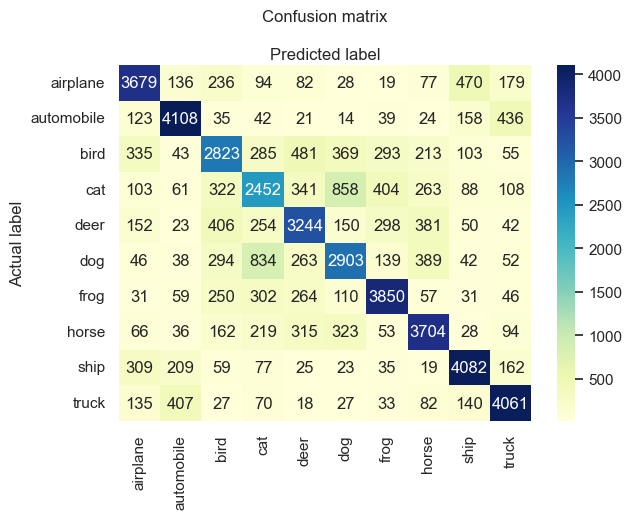

In [39]:

val_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

validate(model, val_loader)

Training Time: 51 minutes, 5.58 seconds

Training Loss: 0.869

Evaluation Accuracy: 69.81%

## Problem 1b

In [67]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(8)
        self.fc1 = nn.Linear(8 * 8 * 2, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        out = self.bn1(F.max_pool2d(torch.tanh(self.conv1(x)), 2))
        out = self.bn2(F.max_pool2d(torch.tanh(self.conv2(out)), 2))
        out = self.bn3(F.max_pool2d(torch.tanh(self.conv3(out)), 2))
        out = out.view(-1, 8 * 8 * 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [70]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

model_1b = Net().to(device)
optimizer = optim.SGD(model_1b.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss().to(device)

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = model_1b,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-10 13:42:12.101521 Epoch 1, Training loss 2.163002387773945
2023-12-10 13:43:54.063801 Epoch 10, Training loss 1.4723345959323577
2023-12-10 13:45:50.843979 Epoch 20, Training loss 1.2498445803178224
2023-12-10 13:47:42.869608 Epoch 30, Training loss 1.1252093109591255
2023-12-10 13:49:33.449538 Epoch 40, Training loss 1.050079665421526
2023-12-10 13:51:23.933147 Epoch 50, Training loss 0.9947156506479928
2023-12-10 13:53:14.776828 Epoch 60, Training loss 0.9534578832629996
2023-12-10 13:55:08.507470 Epoch 70, Training loss 0.9205638309548184
2023-12-10 13:56:59.789920 Epoch 80, Training loss 0.8932963598276921
2023-12-10 13:58:52.254842 Epoch 90, Training loss 0.870658990295454
2023-12-10 14:00:54.195207 Epoch 100, Training loss 0.8476989725997165
2023-12-10 14:02:46.249325 Epoch 110, Training loss 0.8314227299671977
2023-12-10 14:04:37.100583 Epoch 120, Training loss 0.8168435192656243
2023-12-10 14:06:27.721547 Epoch 130, Training loss 0.8009732817781383
2023-12-10 14:08:20.

Validation Accuracy: 76.18%
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      5000
           1       0.86      0.91      0.88      5000
           2       0.70      0.61      0.65      5000
           3       0.63      0.56      0.59      5000
           4       0.67      0.75      0.71      5000
           5       0.66      0.68      0.67      5000
           6       0.83      0.78      0.80      5000
           7       0.75      0.83      0.79      5000
           8       0.85      0.87      0.86      5000
           9       0.87      0.84      0.86      5000

    accuracy                           0.76     50000
   macro avg       0.76      0.76      0.76     50000
weighted avg       0.76      0.76      0.76     50000



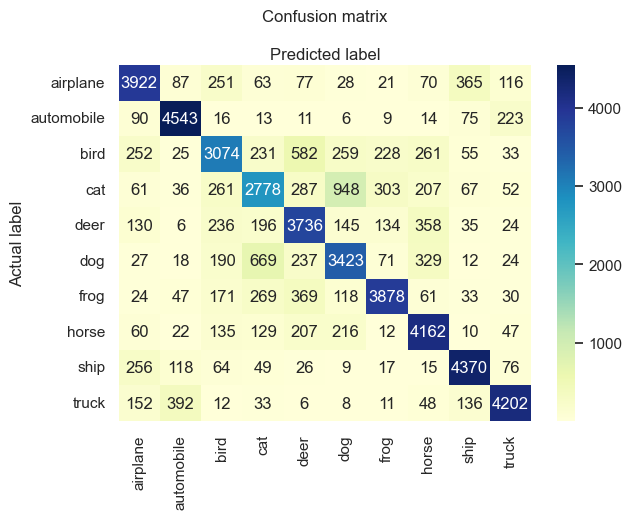

In [71]:
val_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)

validate(model_1b, val_loader)

Training Time: 55 minutes, 55.75 seconds

Training Loss: 0.677

Evaluation Accuracy: 76.18%

This is a more accurate model than the one in problem 1a. It has a greater recall and f1 score than the previous one and doesn't show signs of overfitting yet.

## Problem 2a

In [22]:
class ResBlock(nn.Module):
    def __init__(self, n_chans) -> None:
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [10]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 *self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=192, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=192, shuffle=True)

resnet_10 = NetResDeep(n_chans1=32, n_blocks=10).to(device)
optimizer = optim.SGD(resnet_10.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = resnet_10,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-10 21:12:19.124462 Epoch 1, Training loss 1.955009133879709
2023-12-10 21:14:13.535958 Epoch 10, Training loss 1.173921981533825
2023-12-10 21:16:20.857521 Epoch 20, Training loss 0.9905350368141671
2023-12-10 21:18:28.515804 Epoch 30, Training loss 0.888937902861628
2023-12-10 21:20:36.120212 Epoch 40, Training loss 0.8155990681429018
2023-12-10 21:22:43.105634 Epoch 50, Training loss 0.7581353936615575
2023-12-10 21:24:50.016923 Epoch 60, Training loss 0.7110174720771468
2023-12-10 21:26:56.631759 Epoch 70, Training loss 0.6689117422962554
2023-12-10 21:29:05.835134 Epoch 80, Training loss 0.6317158807283161
2023-12-10 21:31:15.956473 Epoch 90, Training loss 0.6015262870953001
2023-12-10 21:33:25.387550 Epoch 100, Training loss 0.5714634205874812
2023-12-10 21:35:35.250788 Epoch 110, Training loss 0.5433803593518634
2023-12-10 21:37:46.357009 Epoch 120, Training loss 0.5198773023497556
2023-12-10 21:39:56.152960 Epoch 130, Training loss 0.4963250603255641
2023-12-10 21:42:05.

Validation Accuracy: 57.59%
              precision    recall  f1-score   support

           0       0.76      0.55      0.64      1000
           1       0.91      0.64      0.75      1000
           2       0.71      0.24      0.36      1000
           3       0.36      0.53      0.43      1000
           4       0.32      0.89      0.47      1000
           5       0.53      0.48      0.50      1000
           6       0.73      0.71      0.72      1000
           7       0.72      0.61      0.66      1000
           8       0.86      0.62      0.72      1000
           9       0.91      0.49      0.63      1000

    accuracy                           0.58     10000
   macro avg       0.68      0.58      0.59     10000
weighted avg       0.68      0.58      0.59     10000



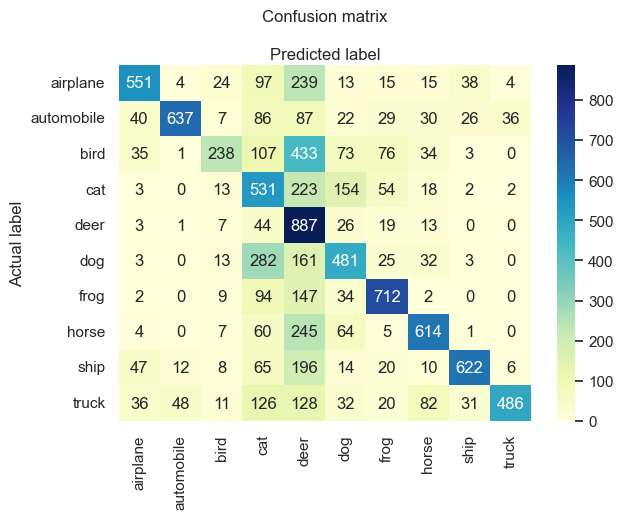

In [31]:
validate(resnet_10, val_loader)

Training Time: 1 hour, 4 minutes, 25.446 seconds

Training Loss: 0.243

Evaluation Accuracy: 57.59%

While the Training Time is mostly the same, taking a little longer to train, and the training loss is significantly lower, the evaluation accuracy has worsened compared to problem 1b.

## Problem 2b

### Weight Decay

In [30]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=192, shuffle=True)

resnet_10_wd = NetResDeep(n_chans1=32, n_blocks=10).to(device)
optimizer = optim.SGD(resnet_10_wd.parameters(), lr=3e-3, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = resnet_10_wd,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2023-12-10 22:45:59.408601 Epoch 1, Training loss 1.936279395047356
2023-12-10 22:48:02.728856 Epoch 10, Training loss 1.1044271681314843
2023-12-10 22:50:22.183298 Epoch 20, Training loss 0.9196464641929587
2023-12-10 22:52:41.705615 Epoch 30, Training loss 0.8090310717177818
2023-12-10 22:54:55.590360 Epoch 40, Training loss 0.734011294667983
2023-12-10 22:57:09.161418 Epoch 50, Training loss 0.6733051836490631
2023-12-10 22:59:22.566193 Epoch 60, Training loss 0.6264525870685382
2023-12-10 23:01:37.975196 Epoch 70, Training loss 0.5840019230037699
2023-12-10 23:03:52.797404 Epoch 80, Training loss 0.5495534273974426
2023-12-10 23:06:08.321877 Epoch 90, Training loss 0.511839002828159
2023-12-10 23:08:22.677876 Epoch 100, Training loss 0.48605124267470806
2023-12-10 23:10:34.931338 Epoch 110, Training loss 0.4619919121875178
2023-12-10 23:12:48.282104 Epoch 120, Training loss 0.4356021911591825
2023-12-10 23:15:02.695154 Epoch 130, Training loss 0.41250222791796143
2023-12-10 23:17:1

Validation Accuracy: 49.94%
              precision    recall  f1-score   support

           0       0.76      0.46      0.57      1000
           1       0.97      0.34      0.51      1000
           2       0.45      0.51      0.48      1000
           3       0.39      0.29      0.33      1000
           4       0.33      0.72      0.46      1000
           5       0.55      0.40      0.46      1000
           6       0.35      0.94      0.51      1000
           7       0.84      0.41      0.55      1000
           8       0.89      0.51      0.65      1000
           9       0.77      0.41      0.53      1000

    accuracy                           0.50     10000
   macro avg       0.63      0.50      0.51     10000
weighted avg       0.63      0.50      0.51     10000



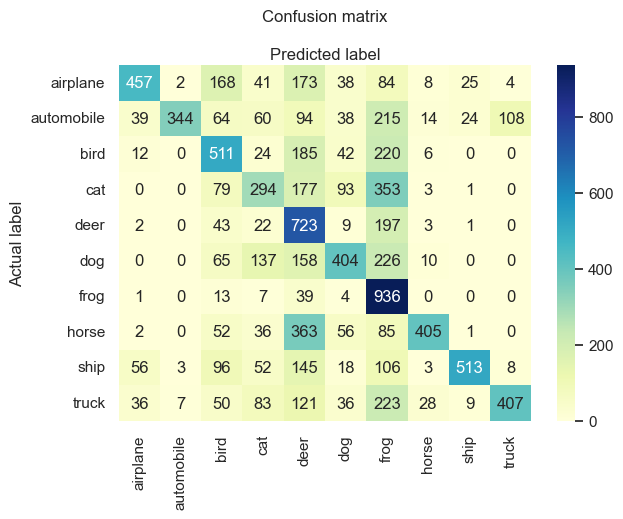

In [32]:
validate(resnet_10_wd, val_loader)

Training Time: 1 hour, 9 minutes, and 32.713 seconds

Training Loss: 0.1811

Evaluation Accuracy: 49.94%

This model performed significantly worse than the previous models, suffering a 26% drop compared to problem 1b.

### Dropout

In [25]:
class ResBlock(nn.Module):
    def __init__(self, n_chans, dropout_prob=0.3) -> None:
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        self.dropout = nn.Dropout(p=dropout_prob)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        out = self.dropout(out)
        return out + x



2023-12-10 19:57:34.511141 Epoch 1, Training loss 1.8704628343777279
2023-12-10 19:59:37.088471 Epoch 10, Training loss 1.12806573807431
2023-12-10 20:01:50.420225 Epoch 20, Training loss 0.9491452138747096
2023-12-10 20:04:03.786208 Epoch 30, Training loss 0.8440565288524189
2023-12-10 20:06:17.093342 Epoch 40, Training loss 0.7688310297248918
2023-12-10 20:08:30.496846 Epoch 50, Training loss 0.7086427893937396
2023-12-10 20:10:46.359858 Epoch 60, Training loss 0.656889976900252
2023-12-10 20:13:04.601041 Epoch 70, Training loss 0.613579998007211
2023-12-10 20:15:19.989829 Epoch 80, Training loss 0.5726325877792086
2023-12-10 20:17:33.336106 Epoch 90, Training loss 0.5374532065275685
2023-12-10 20:19:46.690089 Epoch 100, Training loss 0.5085793403560853
2023-12-10 20:21:59.729542 Epoch 110, Training loss 0.4779258007588594
2023-12-10 20:24:13.454913 Epoch 120, Training loss 0.45446483886150446
2023-12-10 20:26:26.731964 Epoch 130, Training loss 0.4270695934210287
2023-12-10 20:28:39.

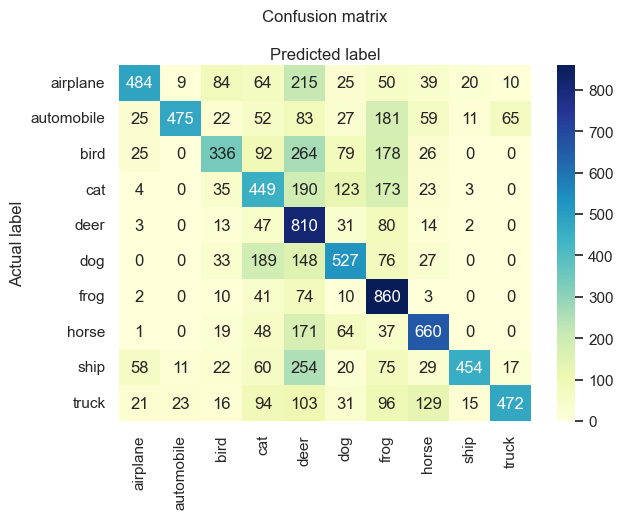

In [27]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=192, shuffle=True)

resnet_10_d = NetResDeep(n_chans1=32, n_blocks=10).to(device)
optimizer = optim.SGD(resnet_10_d.parameters(), lr=3e-3, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = resnet_10_d,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(resnet_10_d, val_loader)

Training Time: 1 hour, 6 minutes, and 49.464 seconds

Training Loss: 0.179

Evaluation Accuracy: 55.27%

This took a little less time than 2a, but performed worse than it overall. However, it did perform better than weight decay did.

### Batch Normalization

In [16]:
import torch.nn as nn

class ResBlock(nn.Module):
    def __init__(self, n_chans) -> None:
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')

    def forward(self, x):
        out = self.conv(x)
        out = torch.relu(out)
        return out + x

2023-12-10 17:23:00.092762 Epoch 1, Training loss nan
2023-12-10 17:24:58.248383 Epoch 10, Training loss nan
2023-12-10 17:27:10.312914 Epoch 20, Training loss nan
2023-12-10 17:29:23.310202 Epoch 30, Training loss nan
2023-12-10 17:31:35.206018 Epoch 40, Training loss nan
2023-12-10 17:33:46.440316 Epoch 50, Training loss nan
2023-12-10 17:36:02.478339 Epoch 60, Training loss nan
2023-12-10 17:38:17.522647 Epoch 70, Training loss nan
2023-12-10 17:40:33.879337 Epoch 80, Training loss nan
2023-12-10 17:42:44.220933 Epoch 90, Training loss nan
2023-12-10 17:44:57.484956 Epoch 100, Training loss nan
2023-12-10 17:47:12.899700 Epoch 110, Training loss nan
2023-12-10 17:49:29.033819 Epoch 120, Training loss nan
2023-12-10 17:51:43.863488 Epoch 130, Training loss nan
2023-12-10 17:54:00.112675 Epoch 140, Training loss nan
2023-12-10 17:56:17.195340 Epoch 150, Training loss nan
2023-12-10 17:58:34.205246 Epoch 160, Training loss nan
2023-12-10 18:00:52.028957 Epoch 170, Training loss nan
202

c:\Users\Sam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sam\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


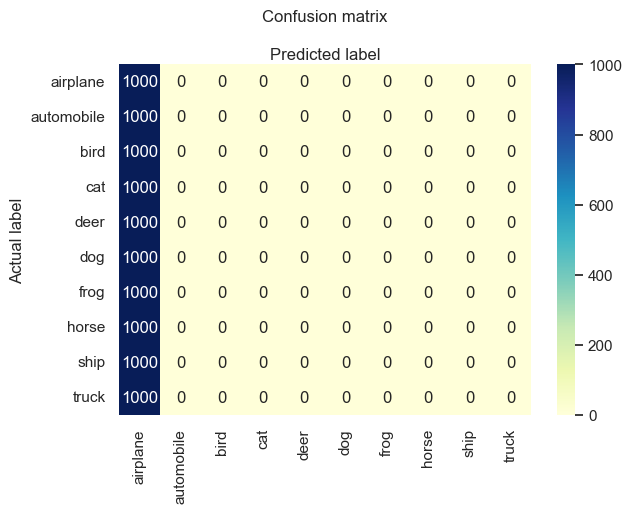

In [18]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=192, shuffle=True)

resnet_10 = NetResDeep(n_chans1=32, n_blocks=10).to(device)
optimizer = optim.SGD(resnet_10.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 300,
    optimizer = optimizer,
    model = resnet_10,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
validate(resnet_10, val_loader)

Training Time: 53 minutes, and 41.99 seconds

Training Loss: nan (basically infinity)

Evaluation Accuracy: 10%

It is likely here that the lack of normalization caused the resblocks to fail in their purpose of training the model.